In [313]:
#import libraries
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [17]:
#mport data
df_metrics = pd.read_csv('Data/metrics_corr.csv')

#remove columns that use kl evaluation metric
kl_list = [col for col in df_metrics.columns if col.endswith('_kl')]
df_metrics.drop(kl_list, axis=1, inplace=True)

In [37]:
#import ranked columns for age and sex (from feature selection)
df_age_cols = pd.read_csv('Data/age_selectk.csv')
df_sex_cols = pd.read_csv('Data/sex_selectk.csv')

In [18]:
#create age categories
df_metrics.loc[(df_metrics['DoB']>1971) & (df_metrics['DoB']<=1983), 'age_class'] = 0
df_metrics.loc[(df_metrics['DoB']>1983) & (df_metrics['DoB']<=1994), 'age_class'] = 1
df_metrics.loc[(df_metrics['DoB']>1994) & (df_metrics['DoB']<=2000), 'age_class'] = 2
df_metrics.loc[(df_metrics['DoB']>2000) & (df_metrics['DoB']<=2011), 'age_class'] = 3

df_metrics['age_class'] = pd.to_numeric(df_metrics['age_class'], downcast = 'integer')
#remove all rows that are not included in age categories
df_metrics = df_metrics[df_metrics.age_class.isnull() == False]

In [21]:
#create gender category varibale
le = LabelEncoder()
df_metrics['age_var'] = le.fit_transform(df_metrics['age_class'])
df_metrics['gender_var'] = le.fit_transform(df_metrics['Gender'])

In [22]:
#create lists that store column names for each saliency map

aim_list = [col for col in df_metrics.columns if col.startswith('aim_')]
rare_list = [col for col in df_metrics.columns if col.startswith('rare_')]
qss_list = [col for col in df_metrics.columns if col.startswith('qss_')]
lds_list = [col for col in df_metrics.columns if col.startswith('lds_')]
imsig_list = [col for col in df_metrics.columns if col.startswith('imsig_')]
ikn_list = [col for col in df_metrics.columns if col.startswith('ikn_')]
gbvs_list = [col for col in df_metrics.columns if col.startswith('gbvs_')]
fes_list = [col for col in df_metrics.columns if col.startswith('fes_')]
dva_list = [col for col in df_metrics.columns if col.startswith('dva_')]
cvs_list = [col for col in df_metrics.columns if col.startswith('cvs_')]
cas_list = [col for col in df_metrics.columns if col.startswith('cas_')]
dgi_list = [col for col in df_metrics.columns if col.startswith('dgi_')]
dgii_list = [col for col in df_metrics.columns if col.startswith('dgii_')]
dgiie_list = [col for col in df_metrics.columns if col.startswith('dgiie_')]
icf_list = [col for col in df_metrics.columns if col.startswith('icf_')]
all_pred = icf_list + dgiie_list + dgii_list + dgi_list + cas_list + cvs_list + dva_list + fes_list + gbvs_list + ikn_list + imsig_list + lds_list + qss_list + rare_list + aim_list

In [30]:
#create train and test data and scale data
X_train, X_test, y_train, y_test = train_test_split(df_metrics[all_pred], df_metrics.age_class, test_size=0.2,random_state=109) # 70% training and 30% test
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [404]:
#feature selection - select k best variables for prediction using f_classification stat (ANOVA)
fs = SelectKBest(f_classif, k='all')
fs.fit(df_metrics[all_pred], df_metrics.age_class)
X = fs.transform(df_metrics[all_pred])

In [406]:
#get all the anova correlations and save to dataframe with column name
selectkb = []
for i in range(len(fs.scores_)):
    selectkb.append([all_pred[i], fs.scores_[i]])

df_selectkb = pd.DataFrame(selectkb, columns = ['col_name','fs_score'])
df_selectkb.sort_values(by='fs_score',ascending = False)

,col_name,fs_score
3,icf_cc,2.590742
69,qss_cc,2.299368
0,icf_nss,2.175220
67,qss_auc,2.069283
70,qss_sauc,2.042680
...,...,...
6,dgiie_nss,0.133108
42,fes_nss,0.094936
47,fes_sim,0.091873
44,fes_ig,0.075347


In [407]:
#save data frame to csv
df_selectkb.to_csv('Data/age_selectk.csv')

In [408]:
#repeat feature selection for sex
fsg = SelectKBest(f_classif, k='all')
fsg.fit(df_metrics[all_pred], df_metrics.gender_var)
Xg = fsg.transform(df_metrics[all_pred])

selectkbg = []
for i in range(len(fsg.scores_)):
    selectkbg.append([all_pred[i], fsg.scores_[i]])

df_selectkbg = pd.DataFrame(selectkbg, columns = ['col_name','fs_score'])
df_selectkbg.sort_values(by='fs_score',ascending = False)

,col_name,fs_score
39,dva_cc,6.715284
45,fes_cc,6.633877
42,fes_nss,6.521824
36,dva_nss,6.387253
72,rare_nss,6.011496
...,...,...
1,icf_auc,0.005917
68,qss_ig,0.005534
3,icf_cc,0.004127
79,aim_auc,0.003335


In [409]:
#save data to csv
df_selectkbg.to_csv('Data/sex_selectk.csv')

# AGE

In [290]:
#select top 50 variables for age (ranked by feature selection)
temp = df_selectkb.nlargest(50,'fs_score')
cols = temp['col_name'].tolist()

In [291]:
#train val test split
X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols], df_metrics.age_class, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [81]:
#convert train data to matrix for xgboost algorithm
dtrain = xgb.DMatrix(data=X_train, label=y_train, feature_names=cols)
dtest = xgb.DMatrix(data=X_test)

In [88]:
#define classifier
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=9,
                    scale_pos_weight = 1,
                    seed=27)

In [89]:
#fit classifier & predict
xgb1.fit(X_train,y_train)
pred = xgb1.predict(X_test)
#print classificaiton result
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

[17:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

         0.0       0.24      0.16      0.19        25
         1.0       0.26      0.25      0.26        36
         2.0       0.22      0.48      0.30        21
         3.0       0.27      0.12      0.17        25

    accuracy                           0.24       107
   macro avg       0.25      0.25      0.23       107
weighted avg       0.25      0.24      0.23       107

Model F1 Score  0.24299065420560748


In [295]:
#define functions for tuning parameters

#function to plot train and test accuracies across epochs
def plot_compare(metrics,eval_results,epochs):
    for m in metrics:
        test_score = eval_results['val'][m]
        train_score = eval_results['train'][m]
        rang = range(0, epochs)
        plt.rcParams["figure.figsize"] = [6,6]
        plt.plot(rang, test_score,"c", label="Val")
        plt.plot(rang, train_score,"orange", label="Train")
        title_name = m + " plot"
        plt.title(title_name)
        plt.xlabel('Iterations')
        plt.ylabel(m)
        lgd = plt.legend()
        plt.show()

#function to fit model
def fitXgb(sk_model, X_train, y_train, X_val, y_val, X_test, y_test,feat, epochs=300):
    print('Fitting model...')
    #fit input model on training data
    sk_model.fit(X_train, y_train)
    print('Fitting done!')
    #convert train and validation data to matrices
    train = xgb.DMatrix(X_train, label=y_train)
    val = xgb.DMatrix(X_val, label=y_val)
    #get parameters of input model
    params = sk_model.get_xgb_params()
    #define metrics for calculating errors
    metrics = ['mlogloss','merror']
    #and add to list of defined parameters
    params['eval_metric'] = metrics
    #create empty dictionary
    store = {}
    #evaluate model on train and validation data
    evallist = [(val, 'val'),(train,'train')]
    #train model with defined parameters on train and validation data, store results in empty dictionary
    xgb_model = xgb.train(params, train, epochs, evallist,evals_result=store,verbose_eval=100)
    print('-- Model Report --')
    #print accuracy score
    print('XGBoost Accuracy: '+str(accuracy_score(sk_model.predict(X_test), y_test)))
    #print f1 score
    print('XGBoost F1-Score (Micro): '+str(f1_score(sk_model.predict(X_test),y_test,average='micro')))
    #plot train and validation loss and error across each epoch
    plot_compare(metrics,store,epochs)
    #define feature names
    features = feat
    f, ax = plt.subplots(figsize=(15,5))
    #plot feature importance for each feature
    feat_imp = pd.Series(sk_model.feature_importances_)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    plt.bar(features,feat_imp)
    plt.ylabel('Feature Importance Score')
    #plot = sns.barplot(x=features, data=feat_imp)
    #ax.set_title('Feature Importance')
    plt.xticks(rotation = 45)
    plt.show()

Fitting model...
[17:59:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting done!
[17:59:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-mlogloss:2.12073	val-merror:0.71318	train-mlogloss:2.03341	train-merror:0.31544


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-mlogloss:1.73840	val-merror:0.72868	train-mlogloss:0.09412	train-merror:0.00000
[200]	val-mlogloss:1.92046	val-merror:0.72093	train-mlogloss:0.03836	train-merror:0.00000
[299]	val-mlogloss:2.02719	val-merror:0.72093	train-mlogloss:0.02624	train-merror:0.00000
-- Model Report --
XGBoost Accuracy: 0.24299065420560748
XGBoost F1-Score (Micro): 0.24299065420560748


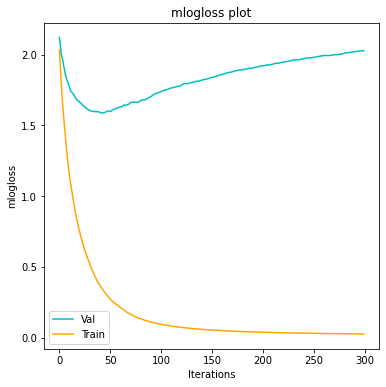

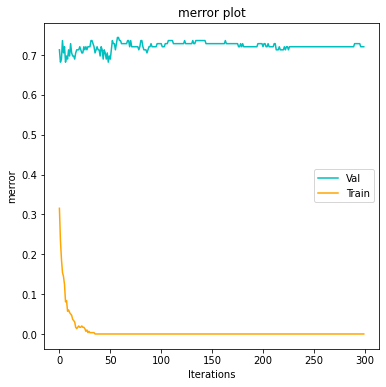

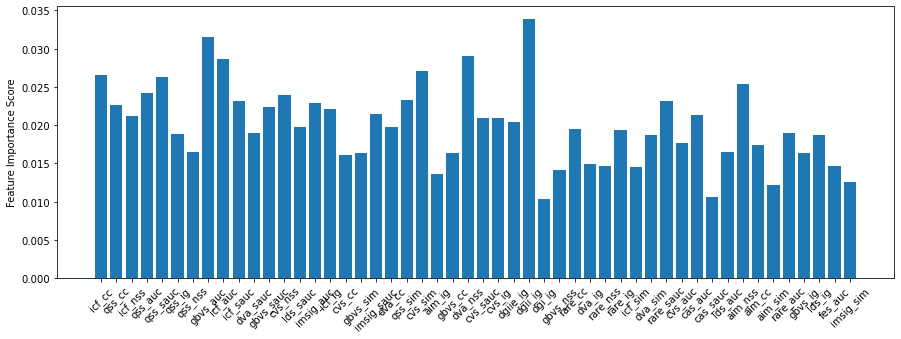

In [91]:
#evaulate first model
fitXgb(xgb1, X_train, y_train, X_val, y_val, X_test, y_test,epochs = 300)

In [94]:
#create function to store results of gridsearch and return best parameters
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

In [92]:
#define parameters and range, run gridsearch across these parameters 
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[18:03:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     callbacks=None, colsample_bylevel=1,
                                     colsample_bynode=1, colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=0, gpu_id=-1,
                                     grow_policy='depthwise',
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.1, max_bin=256,
                                     max_cat_to_onehot=4, max_delta_step=0,
                                     max_depth=5, max_leaves=0,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=1000, n_jobs=4, nthread=4,
                                     num_class=9, num_parallel_tree=1,
                                     objective='multi:softmax',
                                     predictor='auto', ...),
             n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='f1_micro', verbose=10)

In [95]:
#get best parameters scores
getTrainScores(gsearch1)

({0: "mean:0.27186440677966106params{'max_depth': 3, 'min_child_weight': 1}",
  1: "mean:0.292090395480226params{'max_depth': 3, 'min_child_weight': 3}",
  2: "mean:0.29536723163841805params{'max_depth': 3, 'min_child_weight': 5}",
  3: "mean:0.30553672316384184params{'max_depth': 5, 'min_child_weight': 1}",
  4: "mean:0.31220338983050844params{'max_depth': 5, 'min_child_weight': 3}",
  5: "mean:0.29542372881355927params{'max_depth': 5, 'min_child_weight': 5}",
  6: "mean:0.30892655367231636params{'max_depth': 7, 'min_child_weight': 1}",
  7: "mean:0.288587570621469params{'max_depth': 7, 'min_child_weight': 3}",
  8: "mean:0.30542372881355934params{'max_depth': 7, 'min_child_weight': 5}",
  9: "mean:0.27531073446327686params{'max_depth': 9, 'min_child_weight': 1}",
  10: "mean:0.30203389830508476params{'max_depth': 9, 'min_child_weight': 3}",
  11: "mean:0.30536723163841806params{'max_depth': 9, 'min_child_weight': 5}"},
 {'best_mean': 0.31220338983050844,
  'best_param': {'max_depth':

In [97]:
#define parameters and range, run gridsearch across these parameters 
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[2,3,4]
}

gsearch2 = GridSearchCV(estimator = xgb1, param_grid = param_test2, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch2.fit(X_train, y_train)
#get best parameters scores
getTrainScores(gsearch2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[18:08:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




({0: "mean:0.2887570621468926params{'max_depth': 4, 'min_child_weight': 2}",
  1: "mean:0.2854237288135593params{'max_depth': 4, 'min_child_weight': 3}",
  2: "mean:0.29192090395480225params{'max_depth': 4, 'min_child_weight': 4}",
  3: "mean:0.28536723163841804params{'max_depth': 5, 'min_child_weight': 2}",
  4: "mean:0.31220338983050844params{'max_depth': 5, 'min_child_weight': 3}",
  5: "mean:0.29203389830508475params{'max_depth': 5, 'min_child_weight': 4}",
  6: "mean:0.2953107344632769params{'max_depth': 6, 'min_child_weight': 2}",
  7: "mean:0.2819774011299435params{'max_depth': 6, 'min_child_weight': 3}",
  8: "mean:0.2852542372881356params{'max_depth': 6, 'min_child_weight': 4}"},
 {'best_mean': 0.31220338983050844,
  'best_param': {'max_depth': 5, 'min_child_weight': 3}})

Fitting model...
[18:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting done!
[18:13:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-mlogloss:2.12784	val-merror:0.71318	train-mlogloss:2.06368	train-merror:0.43289


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-mlogloss:1.73006	val-merror:0.73643	train-mlogloss:0.17837	train-merror:0.00000
[200]	val-mlogloss:1.85856	val-merror:0.69767	train-mlogloss:0.08773	train-merror:0.00000
[299]	val-mlogloss:1.94864	val-merror:0.72868	train-mlogloss:0.06384	train-merror:0.00000
-- Model Report --
XGBoost Accuracy: 0.2616822429906542
XGBoost F1-Score (Micro): 0.2616822429906542


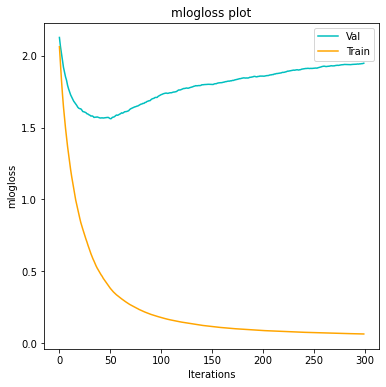

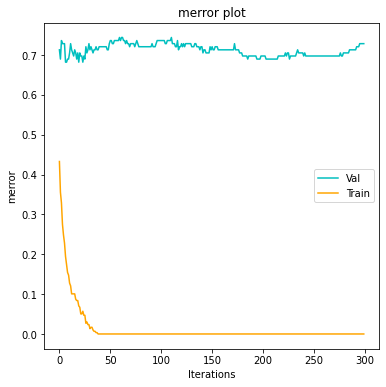

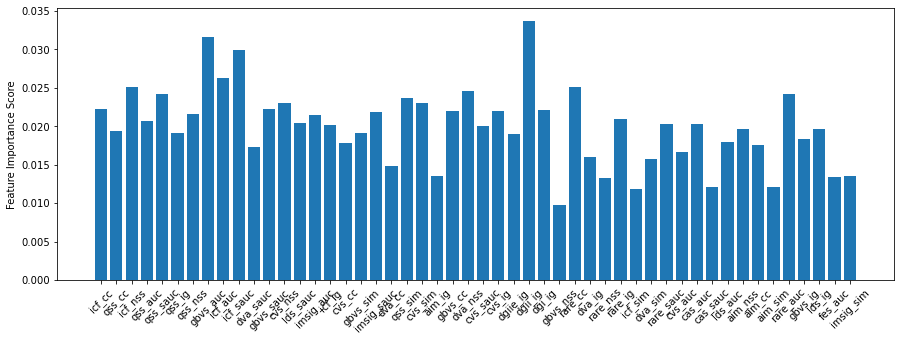

In [101]:
#update model with tuned parameters and fit model, plot errors
xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=3,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=9,
                    scale_pos_weight = 1,
                    seed=27)

fitXgb(xgb2, X_train, y_train, X_val, y_val, X_test, y_test,epochs = 300)

In [102]:
#define parameters and range, run gridsearch across these parameters 

param_test3 = {
 'gamma':[i/10.0 for i in range(0,9)]
}
gsearch3 = GridSearchCV(estimator = xgb2, param_grid = param_test3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch3.fit(X_train, y_train)
#get best parameter values
getTrainScores(gsearch3)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[18:14:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




({0: "mean:0.26515151515151514params{'gamma': 0.0}",
  1: "mean:0.2584848484848485params{'gamma': 0.1}",
  2: "mean:0.29548821548821547params{'gamma': 0.2}",
  3: "mean:0.2954882154882155params{'gamma': 0.3}",
  4: "mean:0.3022558922558923params{'gamma': 0.4}",
  5: "mean:0.2920875420875421params{'gamma': 0.5}",
  6: "mean:0.29218855218855216params{'gamma': 0.6}",
  7: "mean:0.28885521885521886params{'gamma': 0.7}",
  8: "mean:0.298922558922559params{'gamma': 0.8}"},
 {'best_mean': 0.3022558922558923, 'best_param': {'gamma': 0.4}})

Fitting model...
[18:14:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting done!
[18:14:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-mlogloss:2.13682	val-merror:0.74419	train-mlogloss:2.07638	train-merror:0.44966


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-mlogloss:1.61401	val-merror:0.72093	train-mlogloss:0.34648	train-merror:0.00000
[200]	val-mlogloss:1.64208	val-merror:0.72093	train-mlogloss:0.29472	train-merror:0.00000
[299]	val-mlogloss:1.65031	val-merror:0.73643	train-mlogloss:0.27523	train-merror:0.00000
-- Model Report --
XGBoost Accuracy: 0.22429906542056074
XGBoost F1-Score (Micro): 0.22429906542056074


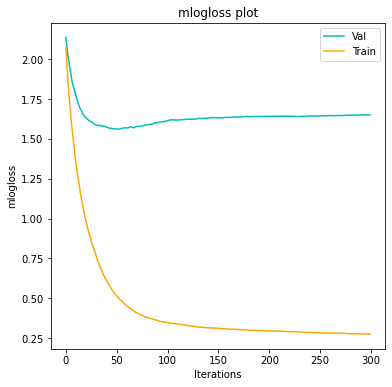

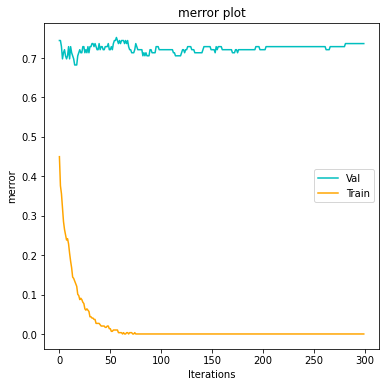

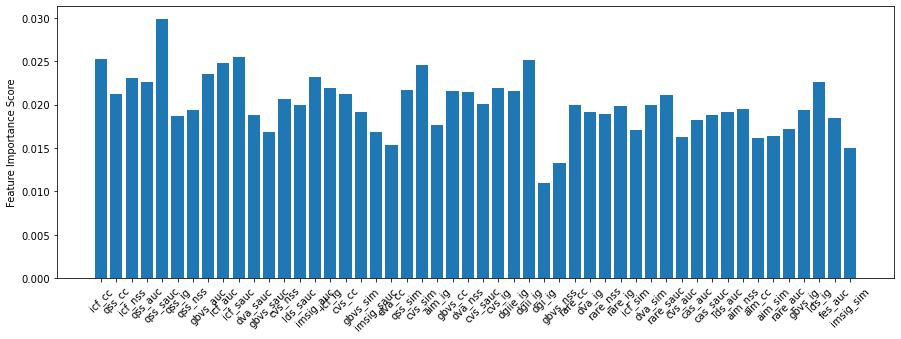

In [103]:
#update model with new parameters and fit model, plot errors
xgb3 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=3,
                    reg_alpha=1,
                    gamma=0.4,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=9,
                    scale_pos_weight = 1,
                    seed=27)

fitXgb(xgb3, X_train, y_train, X_val, y_val, X_test, y_test,epochs = 300)

In [122]:
#define parameters and range, run gridsearch across these parameters 

param_test4 = {
 'subsample':[i/10.0 for i in range(1,10)],
 'colsample_bytree':[i/10.0 for i in range(1,10)]
}
gsearch4 = GridSearchCV(estimator = xgb3, param_grid = param_test4, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch4.fit(X_train, y_train)

getTrainScores(gsearch4)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[18:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




({0: "mean:0.30689466484268124params{'colsample_bytree': 0.1, 'subsample': 0.1}",
  1: "mean:0.2974555403556772params{'colsample_bytree': 0.1, 'subsample': 0.2}",
  2: "mean:0.30216142270861834params{'colsample_bytree': 0.1, 'subsample': 0.3}",
  3: "mean:0.280984952120383params{'colsample_bytree': 0.1, 'subsample': 0.4}",
  4: "mean:0.306703146374829params{'colsample_bytree': 0.1, 'subsample': 0.5}",
  5: "mean:0.28798905608755127params{'colsample_bytree': 0.1, 'subsample': 0.6}",
  6: "mean:0.2997537619699043params{'colsample_bytree': 0.1, 'subsample': 0.7}",
  7: "mean:0.30675786593707255params{'colsample_bytree': 0.1, 'subsample': 0.8}",
  8: "mean:0.30213406292749656params{'colsample_bytree': 0.1, 'subsample': 0.9}",
  9: "mean:0.30207934336525305params{'colsample_bytree': 0.2, 'subsample': 0.1}",
  10: "mean:0.31381668946648433params{'colsample_bytree': 0.2, 'subsample': 0.2}",
  11: "mean:0.30689466484268124params{'colsample_bytree': 0.2, 'subsample': 0.3}",
  12: "mean:0.295047

In [123]:
#define parameters and range, run gridsearch across these parameters 

param_test5 = {
 'subsample':[i/100.0 for i in range(60,80,5)],
 'colsample_bytree':[i/100.0 for i in range(10,30,5)]
}
gsearch5 = GridSearchCV(estimator = xgb3, param_grid = param_test5, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch5.fit(X_train, y_train)

getTrainScores(gsearch5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[18:50:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




({0: "mean:0.28798905608755127params{'colsample_bytree': 0.1, 'subsample': 0.6}",
  1: "mean:0.30207934336525305params{'colsample_bytree': 0.1, 'subsample': 0.65}",
  2: "mean:0.2997537619699043params{'colsample_bytree': 0.1, 'subsample': 0.7}",
  3: "mean:0.29969904240766077params{'colsample_bytree': 0.1, 'subsample': 0.75}",
  4: "mean:0.2903419972640219params{'colsample_bytree': 0.15, 'subsample': 0.6}",
  5: "mean:0.29986320109439124params{'colsample_bytree': 0.15, 'subsample': 0.65}",
  6: "mean:0.28341997264021884params{'colsample_bytree': 0.15, 'subsample': 0.7}",
  7: "mean:0.29269493844049255params{'colsample_bytree': 0.15, 'subsample': 0.75}",
  8: "mean:0.30694938440492475params{'colsample_bytree': 0.2, 'subsample': 0.6}",
  9: "mean:0.2904514363885089params{'colsample_bytree': 0.2, 'subsample': 0.65}",
  10: "mean:0.3209028727770178params{'colsample_bytree': 0.2, 'subsample': 0.7}",
  11: "mean:0.30689466484268124params{'colsample_bytree': 0.2, 'subsample': 0.75}",
  12: "m

Fitting model...
[18:50:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting done!
[18:51:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-mlogloss:2.13280	val-merror:0.72093	train-mlogloss:2.09520	train-merror:0.56376


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-mlogloss:1.55669	val-merror:0.71318	train-mlogloss:0.46097	train-merror:0.00671
[200]	val-mlogloss:1.62144	val-merror:0.71318	train-mlogloss:0.35800	train-merror:0.00000
[299]	val-mlogloss:1.63406	val-merror:0.70543	train-mlogloss:0.32535	train-merror:0.00000
-- Model Report --
XGBoost Accuracy: 0.2336448598130841
XGBoost F1-Score (Micro): 0.23364485981308414


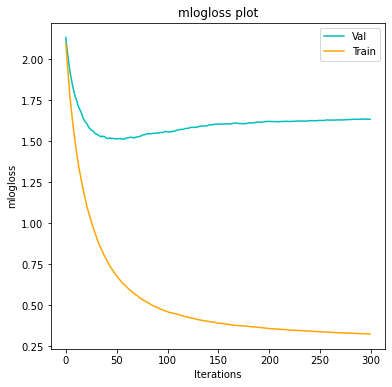

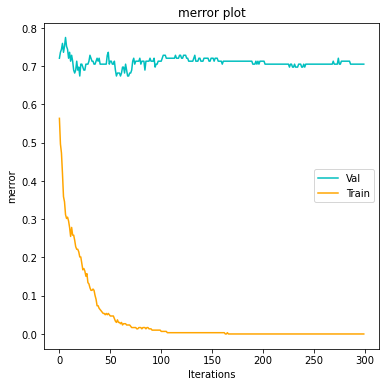

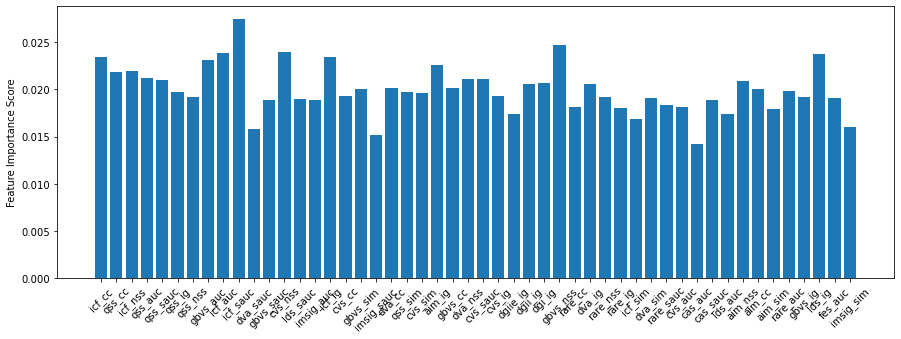

In [126]:
#update model with new parameters and fit model, plot errors

xgb4 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=3,
                    reg_alpha=1,
                    gamma=0.4,
                    subsample=0.65,
                    colsample_bytree=0.25,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=9,
                    scale_pos_weight = 1,
                    seed=27)

fitXgb(xgb4, X_train, y_train, X_val, y_val, X_test, y_test,epochs = 300)

In [128]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb4, param_grid = param_test6, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch6.fit(X_train, y_train)

getTrainScores(gsearch6)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[18:51:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




({0: "mean:0.29214689265536725params{'reg_alpha': 1e-05}",
  1: "mean:0.2989830508474576params{'reg_alpha': 0.01}",
  2: "mean:0.2923163841807909params{'reg_alpha': 0.1}",
  3: "mean:0.29203389830508475params{'reg_alpha': 1}",
  4: "mean:0.25836158192090397params{'reg_alpha': 100}"},
 {'best_mean': 0.2989830508474576, 'best_param': {'reg_alpha': 0.01}})

In [131]:
#define parameters and range, run gridsearch across these parameters 

param_test7 = {
 'reg_alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005,0.01,0.05]
}
gsearch7 = GridSearchCV(estimator = xgb4, param_grid = param_test7, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch7.fit(X_train, y_train)

getTrainScores(gsearch7)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[18:54:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




({0: "mean:0.29214689265536725params{'reg_alpha': 1e-05}",
  1: "mean:0.29214689265536725params{'reg_alpha': 5e-05}",
  2: "mean:0.29548022598870055params{'reg_alpha': 0.0001}",
  3: "mean:0.3056497175141243params{'reg_alpha': 0.0005}",
  4: "mean:0.3024293785310735params{'reg_alpha': 0.001}",
  5: "mean:0.30231638418079093params{'reg_alpha': 0.005}",
  6: "mean:0.2989830508474576params{'reg_alpha': 0.01}",
  7: "mean:0.2888700564971751params{'reg_alpha': 0.05}"},
 {'best_mean': 0.3056497175141243, 'best_param': {'reg_alpha': 0.0005}})

Fitting model...
[23:12:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting done!
[23:13:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-mlogloss:2.18952	val-merror:0.72868	train-mlogloss:2.18289	train-merror:0.42282
[100]	val-mlogloss:1.79608	val-

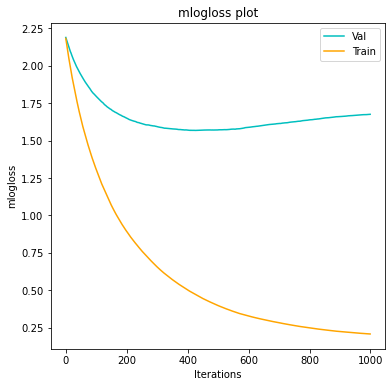

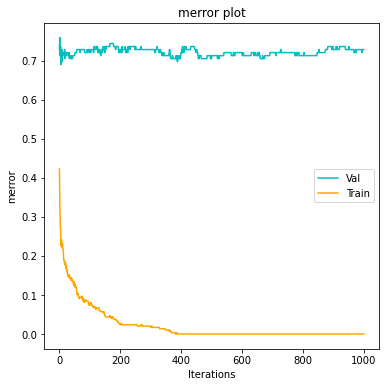

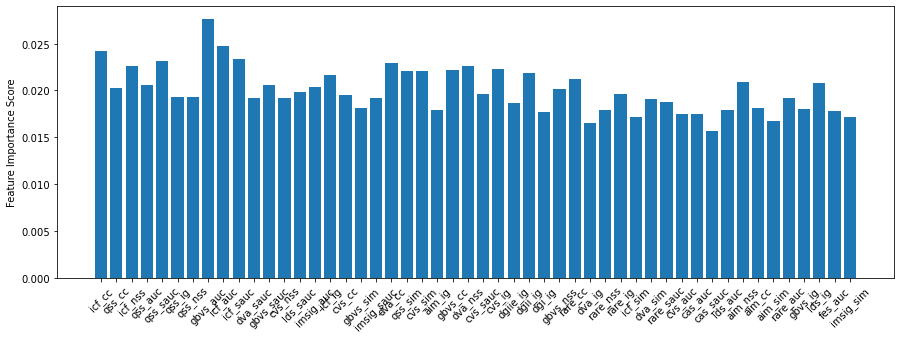

In [296]:
#update model with new parameters and fit model, plot errors

xgb5 = XGBClassifier(learning_rate=0.01,
                    n_estimators=5000,
                    max_depth=5,
                    min_child_weight=3,
                    reg_alpha=0.0005,
                    gamma=0.4,
                    subsample=0.85,
                    colsample_bytree=0.6,
                    objective='multi:softmax',
                    nthread=4,
                    num_class=9,
                    scale_pos_weight = 1,
                    seed=27)

fitXgb(xgb5, X_train, y_train, X_val, y_val, X_test, y_test,cols,epochs = 1000)

In [304]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols], df_metrics.age_class, test_size=0.2, random_state=131)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [134]:
#train tuned model on training data
xgb5.fit(X_train,y_train)
#predict new values
pred = xgb5.predict(X_test)
#print classification results
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

[18:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

         0.0       0.22      0.38      0.28        21
         1.0       0.37      0.30      0.33        33
         2.0       0.37      0.32      0.34        31
         3.0       0.35      0.27      0.31        22

    accuracy                           0.32       107
   macro avg       0.33      0.32      0.32       107
weighted avg       0.34      0.32      0.32       107

Model F1 Score  0.3177570093457944


In [297]:
#get feature importances 
thresholds = np.sort(xgb5.feature_importances_)
fs_age = []

#calculate the accuracy at each level of feature importance and save to df
for thresh in thresholds:
    selection = SelectFromModel(xgb5, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    fs.append([thresh, select_X_train.shape[1], accuracy*100])
    

In [298]:
df_fs = pd.DataFrame(fs, columns = ['thresh','n','accuracy'])

In [299]:
#select the threshold that gives the feature that classify with highest accuracy
df_fs[df_fs.accuracy == df_fs.accuracy.max()]
xgb4.feature_importances_


array([0.13747889, 0.14160813, 0.14802507, 0.14084499, 0.1455988 ,
       0.1467005 , 0.13974367], dtype=float32)

In [300]:
#get id of features that give highest accuracy
idx = [i for i,v in enumerate(xgb4.feature_importances_) if v > 0.023294]
#create subset of these features
selected_features = np.take(cols, idx)

In [316]:
#split subsetted data into train and test and scale
X_train, X_test, y_train, y_test = train_test_split(df_metrics[selected_features], df_metrics.age_class, test_size=0.2, random_state=131)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [303]:
#train model on new subsetted data
xgb5.fit(X_train,y_train)
pred = xgb5.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

[23:15:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


              precision    recall  f1-score   support

         0.0       0.29      0.48      0.36        21
         1.0       0.38      0.36      0.37        33
         2.0       0.41      0.35      0.38        31
         3.0       0.29      0.18      0.22        22

    accuracy                           0.35       107
   macro avg       0.34      0.34      0.33       107
weighted avg       0.35      0.35      0.34       107

Model F1 Score  0.34579439252336447


In [317]:
#run cross validation on final model and selected features
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(xgb5, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
xgb5.fit(X_train, y_train)
pred = xgb5.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

[00:15:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:16:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:16:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be 

In [306]:
#train val test split on selected features data
X_train, X_test, y_train, y_test = train_test_split(df_metrics[selected_features], df_metrics.age_class, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

Fitting model...
[23:17:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting done!
[23:18:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	val-mlogloss:2.18987	val-merror:0.68992	train-mlogloss:2.18496	train-merror:0.48993


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-mlogloss:1.82571	val-merror:0.77519	train-mlogloss:1.44563	train-merror:0.28188
[200]	val-mlogloss:1.69875	val-merror:0.75969	train-mlogloss:1.09793	train-merror:0.22483
[300]	val-mlogloss:1.65118	val-merror:0.75194	train-mlogloss:0.90063	train-merror:0.18456
[400]	val-mlogloss:1.63411	val-merror:0.75194	train-mlogloss:0.76964	train-merror:0.13423
[500]	val-mlogloss:1.63155	val-merror:0.73643	train-mlogloss:0.67901	train-merror:0.10738
[600]	val-mlogloss:1.64554	val-merror:0.72868	train-mlogloss:0.60888	train-merror:0.08389
[700]	val-mlogloss:1.67311	val-merror:0.72868	train-mlogloss:0.56065	train-merror:0.06376
[800]	val-mlogloss:1.69787	val-merror:0.72868	train-mlogloss:0.51991	train-merror:0.04362
[900]	val-mlogloss:1.72036	val-merror:0.72868	train-mlogloss:0.48694	train-merror:0.03356
[999]	val-mlogloss:1.74061	val-merror:0.72868	train-mlogloss:0.45808	train-merror:0.02349
-- Model Report --
XGBoost Accuracy: 0.24299065420560748
XGBoost F1-Score (Micro): 0.242990654205607

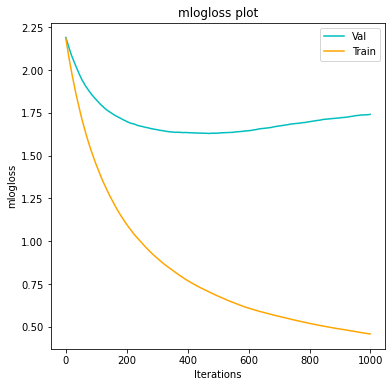

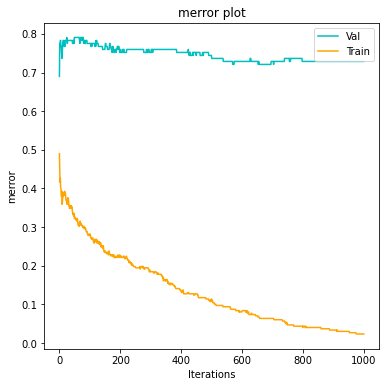

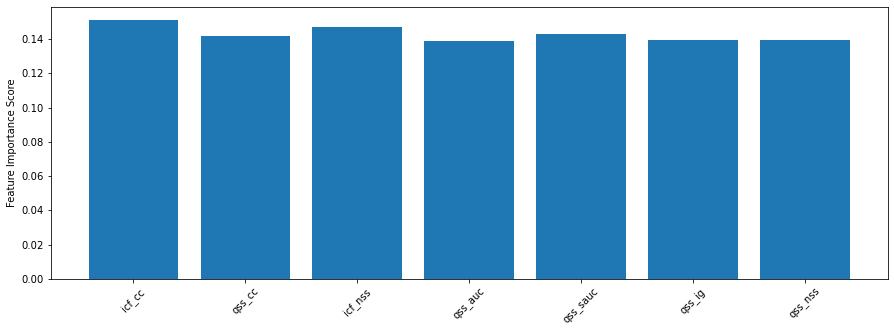

In [308]:
#fit model and to check error plots with subset data
fitXgb(xgb5, X_train, y_train, X_val, y_val, X_test, y_test,selected_features,epochs = 1000)

# SEX

In [318]:
#select top 50 variables for sex (ranked by feature selection)

temp = df_selectkbg.nlargest(50,'fs_score')
cols = temp['col_name'].tolist()

In [319]:
#train val test split for sex and scale
X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols], df_metrics.gender_var, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [160]:
#define first model, train and calculate accuracy
xgb1 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight = 1,
                    seed=27)

xgb1.fit(X_train,y_train)
pred = xgb1.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

              precision    recall  f1-score   support

           0       0.48      0.62      0.54        42
           1       0.70      0.57      0.63        65

    accuracy                           0.59       107
   macro avg       0.59      0.59      0.58       107
weighted avg       0.61      0.59      0.59       107

Model F1 Score  0.5887850467289719


Fitting model...
Fitting done!
[0]	val-logloss:0.69861	val-error:0.54264	train-logloss:0.65846	train-error:0.22148


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-logloss:0.93121	val-error:0.55039	train-logloss:0.08667	train-error:0.00000
[200]	val-logloss:1.07736	val-error:0.52713	train-logloss:0.04234	train-error:0.00000
[299]	val-logloss:1.16464	val-error:0.53488	train-logloss:0.02982	train-error:0.00000
-- Model Report --
XGBoost Accuracy: 0.5887850467289719
XGBoost F1-Score (Micro): 0.5887850467289719


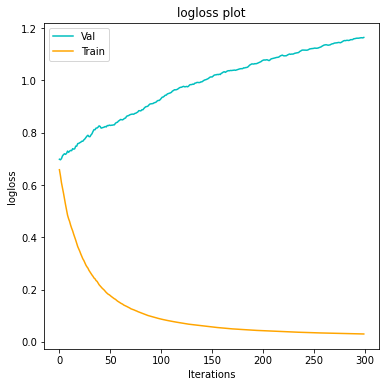

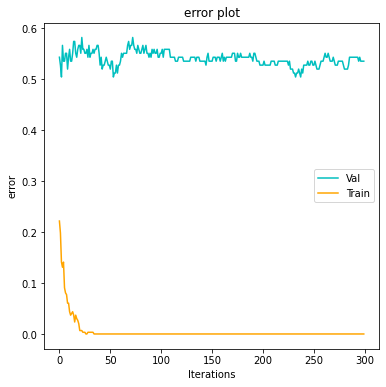

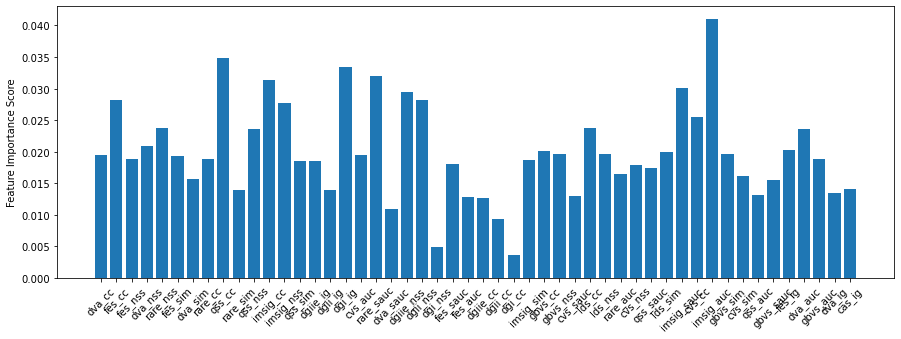

In [161]:
#check error plots for this model
fitXgb(xgb1, X_train, y_train, X_val, y_val, X_test, y_test,epochs = 300)

In [164]:
#define parameters and range, run gridsearch across these parameters 

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch1.fit(X_train, y_train)

#get best parameter scores
getTrainScores(gsearch1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


({0: "mean:0.5372316384180792params{'max_depth': 3, 'min_child_weight': 1}",
  1: "mean:0.5270056497175142params{'max_depth': 3, 'min_child_weight': 3}",
  2: "mean:0.5236158192090394params{'max_depth': 3, 'min_child_weight': 5}",
  3: "mean:0.5105084745762712params{'max_depth': 5, 'min_child_weight': 1}",
  4: "mean:0.5305649717514125params{'max_depth': 5, 'min_child_weight': 3}",
  5: "mean:0.5336158192090397params{'max_depth': 5, 'min_child_weight': 5}",
  6: "mean:0.5472316384180791params{'max_depth': 7, 'min_child_weight': 1}",
  7: "mean:0.5370621468926554params{'max_depth': 7, 'min_child_weight': 3}",
  8: "mean:0.5437853107344633params{'max_depth': 7, 'min_child_weight': 5}",
  9: "mean:0.5272881355932204params{'max_depth': 9, 'min_child_weight': 1}",
  10: "mean:0.5403954802259887params{'max_depth': 9, 'min_child_weight': 3}",
  11: "mean:0.5437853107344633params{'max_depth': 9, 'min_child_weight': 5}"},
 {'best_mean': 0.5472316384180791,
  'best_param': {'max_depth': 7, 'min_

In [166]:
#define parameters and range, run gridsearch across these parameters 

param_test2 = {
 'max_depth':[6,7,8],
 'min_child_weight':[1,2]
}

gsearch2 = GridSearchCV(estimator = xgb1, param_grid = param_test2, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch2.fit(X_train, y_train)

getTrainScores(gsearch2)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


({0: "mean:0.5240677966101694params{'max_depth': 6, 'min_child_weight': 1}",
  1: "mean:0.5338983050847458params{'max_depth': 6, 'min_child_weight': 2}",
  2: "mean:0.5472316384180791params{'max_depth': 7, 'min_child_weight': 1}",
  3: "mean:0.5505084745762712params{'max_depth': 7, 'min_child_weight': 2}",
  4: "mean:0.5272881355932204params{'max_depth': 8, 'min_child_weight': 1}",
  5: "mean:0.5270056497175142params{'max_depth': 8, 'min_child_weight': 2}"},
 {'best_mean': 0.5505084745762712,
  'best_param': {'max_depth': 7, 'min_child_weight': 2}})

Fitting model...
Fitting done!
[0]	val-logloss:0.70279	val-error:0.55814	train-logloss:0.66468	train-error:0.26846


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-logloss:0.98591	val-error:0.55814	train-logloss:0.10921	train-error:0.00000
[200]	val-logloss:1.10040	val-error:0.58140	train-logloss:0.06404	train-error:0.00000
[299]	val-logloss:1.17164	val-error:0.54264	train-logloss:0.04926	train-error:0.00000
-- Model Report --
XGBoost Accuracy: 0.5700934579439252
XGBoost F1-Score (Micro): 0.5700934579439252


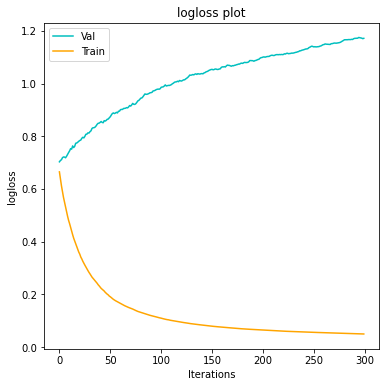

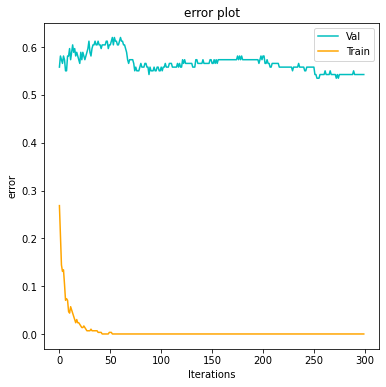

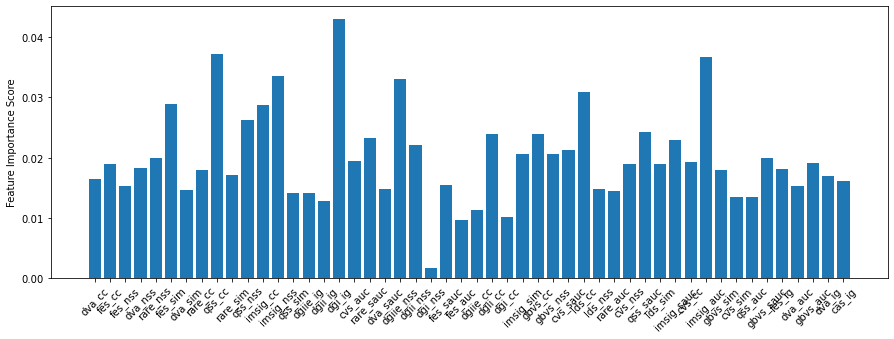

In [167]:
#update model with new parameters and fit model, plot errors

xgb2 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=7,
                    min_child_weight=2,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight = 1,
                    seed=27)

fitXgb(xgb2, X_train, y_train, X_val, y_val, X_test, y_test,epochs = 300)

In [168]:
#define parameters and range, run gridsearch across these parameters 

param_test3 = {
 'gamma':[i/10.0 for i in range(0,9)]
}

gsearch3 = GridSearchCV(estimator = xgb2, param_grid = param_test3, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch3.fit(X_train, y_train)

getTrainScores(gsearch3)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


({0: "mean:0.5505084745762712params{'gamma': 0.0}",
  1: "mean:0.5305649717514125params{'gamma': 0.1}",
  2: "mean:0.5204519774011299params{'gamma': 0.2}",
  3: "mean:0.516949152542373params{'gamma': 0.3}",
  4: "mean:0.5305084745762711params{'gamma': 0.4}",
  5: "mean:0.5272881355932204params{'gamma': 0.5}",
  6: "mean:0.5507909604519774params{'gamma': 0.6}",
  7: "mean:0.5271186440677965params{'gamma': 0.7}",
  8: "mean:0.543954802259887params{'gamma': 0.8}"},
 {'best_mean': 0.5507909604519774, 'best_param': {'gamma': 0.6}})

Fitting model...
Fitting done!
[0]	val-logloss:0.70279	val-error:0.55814	train-logloss:0.66468	train-error:0.26846


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-logloss:0.92606	val-error:0.56589	train-logloss:0.11753	train-error:0.00000
[200]	val-logloss:0.99332	val-error:0.56589	train-logloss:0.09008	train-error:0.00000
[299]	val-logloss:1.00671	val-error:0.57364	train-logloss:0.08391	train-error:0.00000
-- Model Report --
XGBoost Accuracy: 0.5420560747663551
XGBoost F1-Score (Micro): 0.5420560747663551


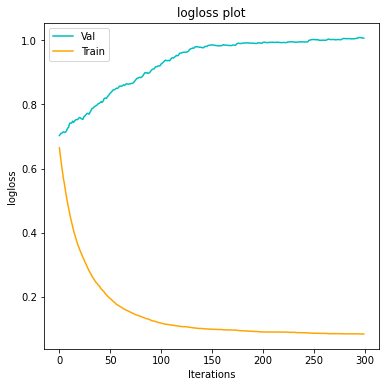

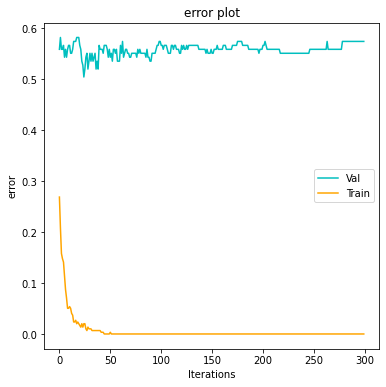

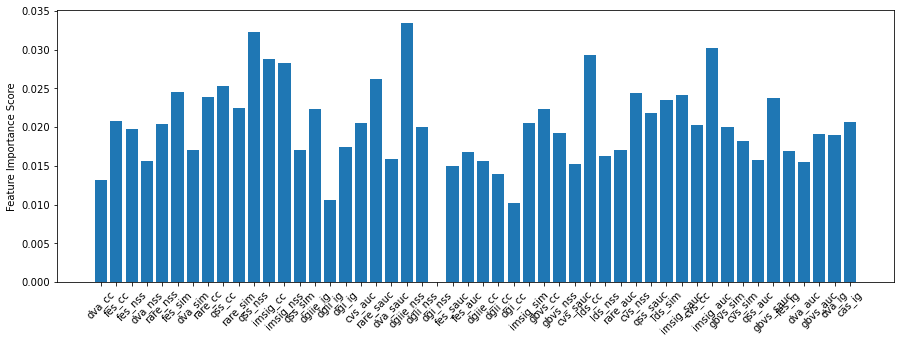

In [169]:
#update model with new parameters and fit model, plot errors

xgb3 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=7,
                    min_child_weight=2,
                    gamma=0.6,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight = 1,
                    seed=27)

fitXgb(xgb3, X_train, y_train, X_val, y_val, X_test, y_test,epochs = 300)

In [170]:
#define parameters and range, run gridsearch across these parameters 

param_test4 = {
 'subsample':[i/10.0 for i in range(1,10)],
 'colsample_bytree':[i/10.0 for i in range(1,10)]
}
gsearch4 = GridSearchCV(estimator = xgb3, param_grid = param_test4, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch4.fit(X_train, y_train)

getTrainScores(gsearch4)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


({0: "mean:0.54045197740113params{'colsample_bytree': 0.1, 'subsample': 0.1}",
  1: "mean:0.537175141242938params{'colsample_bytree': 0.1, 'subsample': 0.2}",
  2: "mean:0.5370621468926553params{'colsample_bytree': 0.1, 'subsample': 0.3}",
  3: "mean:0.5501129943502825params{'colsample_bytree': 0.1, 'subsample': 0.4}",
  4: "mean:0.5605084745762712params{'colsample_bytree': 0.1, 'subsample': 0.5}",
  5: "mean:0.5638418079096045params{'colsample_bytree': 0.1, 'subsample': 0.6}",
  6: "mean:0.5571186440677967params{'colsample_bytree': 0.1, 'subsample': 0.7}",
  7: "mean:0.5271186440677965params{'colsample_bytree': 0.1, 'subsample': 0.8}",
  8: "mean:0.5205649717514124params{'colsample_bytree': 0.1, 'subsample': 0.9}",
  9: "mean:0.5101694915254238params{'colsample_bytree': 0.2, 'subsample': 0.1}",
  10: "mean:0.5169491525423728params{'colsample_bytree': 0.2, 'subsample': 0.2}",
  11: "mean:0.5609604519774012params{'colsample_bytree': 0.2, 'subsample': 0.3}",
  12: "mean:0.550621468926553

In [171]:
#define parameters and range, run gridsearch across these parameters 

param_test5 = {
 'subsample':[i/100.0 for i in range(10,30,5)],
 'colsample_bytree':[i/100.0 for i in range(30,50,5)]
}
gsearch5 = GridSearchCV(estimator = xgb3, param_grid = param_test5, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch5.fit(X_train, y_train)

getTrainScores(gsearch5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


({0: "mean:0.5369491525423729params{'colsample_bytree': 0.3, 'subsample': 0.1}",
  1: "mean:0.5267796610169492params{'colsample_bytree': 0.3, 'subsample': 0.15}",
  2: "mean:0.5403389830508475params{'colsample_bytree': 0.3, 'subsample': 0.2}",
  3: "mean:0.5335593220338983params{'colsample_bytree': 0.3, 'subsample': 0.25}",
  4: "mean:0.4966101694915254params{'colsample_bytree': 0.35, 'subsample': 0.1}",
  5: "mean:0.5436723163841808params{'colsample_bytree': 0.35, 'subsample': 0.15}",
  6: "mean:0.5638983050847457params{'colsample_bytree': 0.35, 'subsample': 0.2}",
  7: "mean:0.5070621468926554params{'colsample_bytree': 0.35, 'subsample': 0.25}",
  8: "mean:0.5369491525423729params{'colsample_bytree': 0.4, 'subsample': 0.1}",
  9: "mean:0.5436158192090396params{'colsample_bytree': 0.4, 'subsample': 0.15}",
  10: "mean:0.5674011299435028params{'colsample_bytree': 0.4, 'subsample': 0.2}",
  11: "mean:0.5337288135593221params{'colsample_bytree': 0.4, 'subsample': 0.25}",
  12: "mean:0.51

Fitting model...
Fitting done!
[0]	val-logloss:0.69777	val-error:0.55039	train-logloss:0.69071	train-error:0.47651
[100]	val-logloss:0.78009	val-error:0.52713	train-logloss:0.48077	train-error:0.19463


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[200]	val-logloss:0.82807	val-error:0.51163	train-logloss:0.40278	train-error:0.13758
[299]	val-logloss:0.89756	val-error:0.51163	train-logloss:0.35134	train-error:0.08389
-- Model Report --
XGBoost Accuracy: 0.5887850467289719
XGBoost F1-Score (Micro): 0.5887850467289719


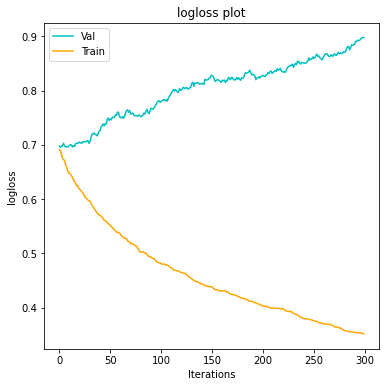

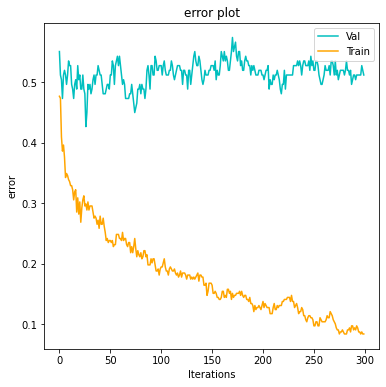

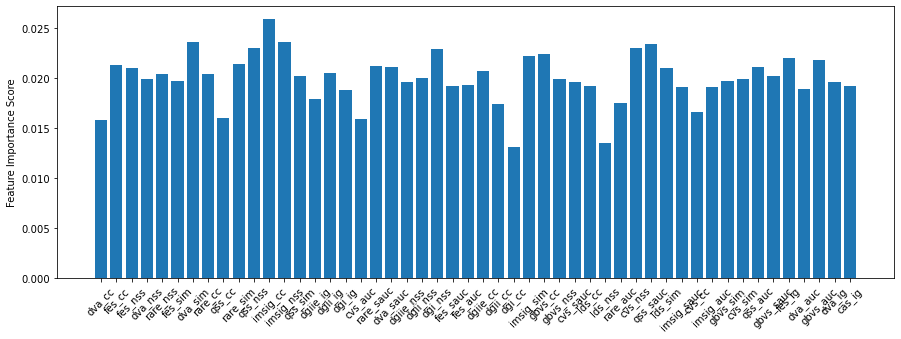

In [322]:
#update model with new parameters and fit model, plot errors

xgb4 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=7,
                    min_child_weight=2,
                    reg_alpha=1,
                    gamma=0.6,
                    subsample=0.2,
                    colsample_bytree=0.4,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight = 1,
                    seed=27)

fitXgb(xgb4, X_train, y_train, X_val, y_val, X_test, y_test,cols,epochs = 300)

In [195]:
#define parameters and range, run gridsearch across these parameters 

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb4, param_grid = param_test6, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch6.fit(X_train, y_train)

getTrainScores(gsearch6)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


({0: "mean:0.5674011299435028params{'reg_alpha': 1e-05}",
  1: "mean:0.5338983050847459params{'reg_alpha': 0.01}",
  2: "mean:0.5606214689265536params{'reg_alpha': 0.1}",
  3: "mean:0.5505649717514125params{'reg_alpha': 1}",
  4: "mean:0.5params{'reg_alpha': 100}"},
 {'best_mean': 0.5674011299435028, 'best_param': {'reg_alpha': 1e-05}})

In [196]:
#define parameters and range, run gridsearch across these parameters 

param_test7 = {
 'reg_alpha':[1e-5,1e-4,1e-3,5e-5,1e-6,5e-6]
}
gsearch7 = GridSearchCV(estimator = xgb4, param_grid = param_test7, scoring='f1_micro',n_jobs=-1,verbose = 10, cv=5)
gsearch7.fit(X_train, y_train)

getTrainScores(gsearch7)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


({0: "mean:0.5674011299435028params{'reg_alpha': 1e-05}",
  1: "mean:0.5674011299435028params{'reg_alpha': 0.0001}",
  2: "mean:0.5774011299435029params{'reg_alpha': 0.001}",
  3: "mean:0.5674011299435028params{'reg_alpha': 5e-05}",
  4: "mean:0.5674011299435028params{'reg_alpha': 1e-06}",
  5: "mean:0.5674011299435028params{'reg_alpha': 5e-06}"},
 {'best_mean': 0.5774011299435029, 'best_param': {'reg_alpha': 0.001}})

Fitting model...
Fitting done!
[0]	val-logloss:0.69829	val-error:0.55814	train-logloss:0.68874	train-error:0.44295


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-logloss:0.80978	val-error:0.48062	train-logloss:0.43525	train-error:0.16107
[200]	val-logloss:0.89278	val-error:0.54264	train-logloss:0.34100	train-error:0.08389
[300]	val-logloss:0.98035	val-error:0.51163	train-logloss:0.28352	train-error:0.06711
[400]	val-logloss:1.00342	val-error:0.51938	train-logloss:0.24682	train-error:0.02685
[500]	val-logloss:1.03555	val-error:0.51163	train-logloss:0.22055	train-error:0.02685
[600]	val-logloss:1.09307	val-error:0.51938	train-logloss:0.19833	train-error:0.01007
[700]	val-logloss:1.11417	val-error:0.53488	train-logloss:0.18050	train-error:0.01007
[800]	val-logloss:1.14193	val-error:0.55814	train-logloss:0.17049	train-error:0.01007
[900]	val-logloss:1.16359	val-error:0.50388	train-logloss:0.16141	train-error:0.00671
[999]	val-logloss:1.17540	val-error:0.51938	train-logloss:0.15423	train-error:0.00671
-- Model Report --
XGBoost Accuracy: 0.5700934579439252
XGBoost F1-Score (Micro): 0.5700934579439252


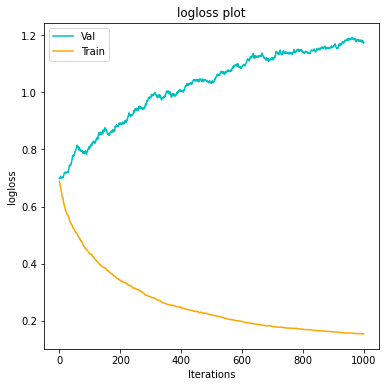

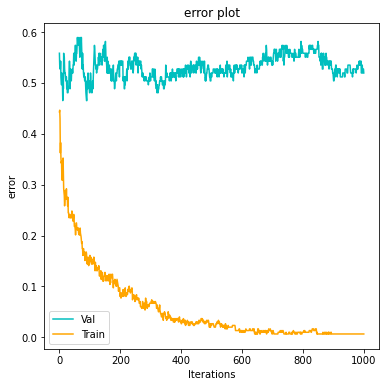

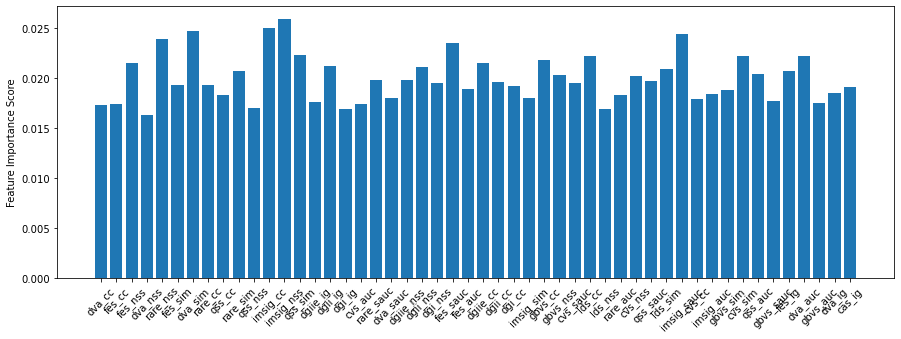

In [206]:
#update model with new parameters and fit model, plot errors

xgb5 = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    max_depth=7,
                    min_child_weight=2,
                    reg_alpha=0.001,
                    gamma=0.6,
                    subsample=0.2,
                    colsample_bytree=0.4,
                    objective='binary:logistic',
                    nthread=4,
                    scale_pos_weight = 1,
                    seed=27)

fitXgb(xgb5, X_train, y_train, X_val, y_val, X_test, y_test,epochs = 1000)

In [242]:
#split data to train and test and scale
X_train, X_test, y_train, y_test = train_test_split(df_metrics[cols], df_metrics.gender_var, test_size=0.2, random_state=131)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

C:\Users\njeri\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [244]:
#train model
xgb5.fit(X_train,y_train)
pred = xgb5.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

              precision    recall  f1-score   support

           0       0.43      0.43      0.43        53
           1       0.44      0.44      0.44        54

    accuracy                           0.44       107
   macro avg       0.44      0.44      0.44       107
weighted avg       0.44      0.44      0.44       107

Model F1 Score  0.4392523364485981


In [243]:
#train 4th model to check accuracy for comparison
xgb4.fit(X_train,y_train)
pred = xgb4.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

              precision    recall  f1-score   support

           0       0.47      0.43      0.45        53
           1       0.48      0.52      0.50        54

    accuracy                           0.48       107
   macro avg       0.48      0.48      0.48       107
weighted avg       0.48      0.48      0.48       107

Model F1 Score  0.4766355140186916


In [323]:
#use model 4 since results are better
#select only relevant features same as with age
thresholds = np.sort(xgb4.feature_importances_)
fs = []
for thresh in thresholds:
    selection = SelectFromModel(xgb4, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    fs.append([thresh, select_X_train.shape[1], accuracy*100])
    

In [324]:
df_fs = pd.DataFrame(fs, columns = ['thresh','n','accuracy'])

In [325]:
df_fs[df_fs.accuracy == df_fs.accuracy.max()]

,thresh,n,accuracy
22,0.019907,28,58.878505
24,0.019957,26,58.878505


In [245]:
xgb4.feature_importances_

array([0.01775733, 0.02041914, 0.0146843 , 0.01883275, 0.02115265,
       0.02111434, 0.0205974 , 0.0172558 , 0.02123138, 0.01907151,
       0.01887622, 0.02601651, 0.01888193, 0.01621621, 0.01859423,
       0.02130624, 0.02331076, 0.02013286, 0.01978854, 0.0232944 ,
       0.01848064, 0.02132214, 0.02158665, 0.01968079, 0.01787543,
       0.02096145, 0.02254678, 0.02051282, 0.02066727, 0.02255198,
       0.02107517, 0.01919787, 0.02139403, 0.01661815, 0.01760719,
       0.01919528, 0.02066915, 0.02072528, 0.02059731, 0.01814966,
       0.02579121, 0.01774032, 0.01893247, 0.01959341, 0.02228644,
       0.01990458, 0.01874366, 0.01964657, 0.01834237, 0.01906939],
      dtype=float32)

In [326]:
idx = [i for i,v in enumerate(xgb4.feature_importances_) if v > 0.019907]

In [327]:
selected_features_sex = np.take(cols, idx)

In [328]:
#resplit data with only selected columns
X_train, X_test, y_train, y_test = train_test_split(df_metrics[selected_features_sex], df_metrics.gender_var, test_size=0.2, random_state=131)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [257]:
#train model with new data
xgb4.fit(X_train,y_train)
pred = xgb4.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

              precision    recall  f1-score   support

           0       0.51      0.47      0.49        53
           1       0.52      0.56      0.54        54

    accuracy                           0.51       107
   macro avg       0.51      0.51      0.51       107
weighted avg       0.51      0.51      0.51       107

Model F1 Score  0.514018691588785


In [259]:
X_train, X_test, y_train, y_test = train_test_split(df_metrics[selected_features], df_metrics.gender_var, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)
y_train = le.fit_transform(y_train)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

Fitting model...
Fitting done!
[0]	val-logloss:0.69909	val-error:0.58915	train-logloss:0.69006	train-error:0.43960


C:\Users\njeri\anaconda3\lib\site-packages\xgboost\core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	val-logloss:0.73639	val-error:0.55814	train-logloss:0.62544	train-error:0.32215
[200]	val-logloss:0.74046	val-error:0.50388	train-logloss:0.59259	train-error:0.30537
[299]	val-logloss:0.76456	val-error:0.51938	train-logloss:0.57436	train-error:0.29195
-- Model Report --
XGBoost Accuracy: 0.5420560747663551
XGBoost F1-Score (Micro): 0.5420560747663551


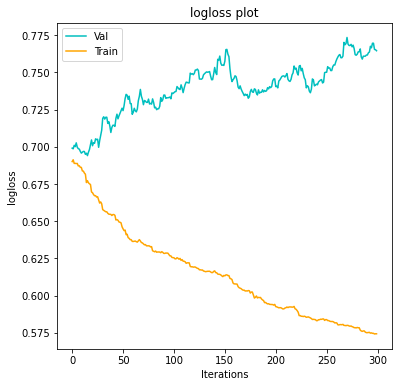

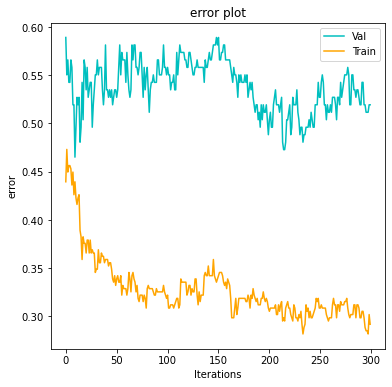

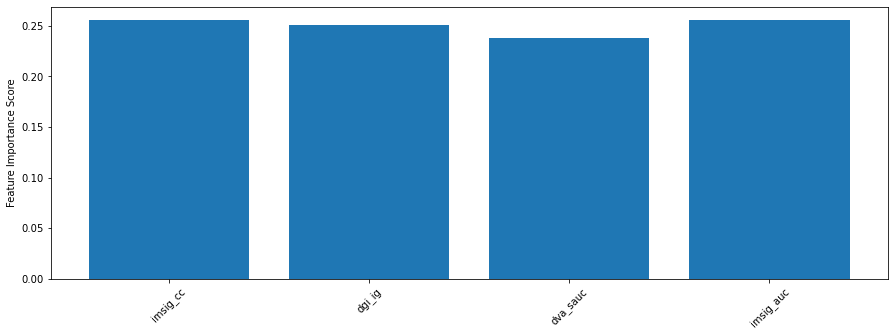

In [264]:
fitXgb(xgb4, X_train, y_train, X_val, y_val, X_test, y_test, selected_features, epochs = 300)

In [331]:
#cross validate final model
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(xgb4, X_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
xgb4.fit(X_train, y_train)
pred = xgb4.predict(X_test)
print(classification_report(y_test, pred))
print("Model F1 Score ", f1_score(y_test, pred, average = 'micro'))

Baseline: 48.72% (6.07%)
              precision    recall  f1-score   support

           0       0.56      0.38      0.45        53
           1       0.54      0.70      0.61        54

    accuracy                           0.54       107
   macro avg       0.55      0.54      0.53       107
weighted avg       0.55      0.54      0.53       107

Model F1 Score  0.5420560747663551
